EMG Signal Processing Pipeline - Real Data Analysis

This notebook analyzes real EMG data from RawEMG.csv (single-channel BICEP recording)

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, spectrogram

## Load BITalino EMG Data

In [67]:
# Load the BITalino EMG data
df = pd.read_csv('bitalino_recording_20251117_235117.csv')

print(f"Data shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

# Extract time array (already in seconds)
timestamps = df['Time(s)'].values

# Calculate sampling rate from time column
duration = timestamps[-1] - timestamps[0]
n_samples = len(timestamps)
fs = n_samples / duration

print(f"\nData characteristics:")
print(f"  Duration: {duration:.2f} seconds")
print(f"  Number of samples: {n_samples}")
print(f"  Sampling rate: {fs:.1f} Hz")

# Display available analog channels
print(f"\nAvailable analog channels:")
for col in df.columns:
    if col.startswith('Analog'):
        values = df[col].values
        print(f"  {col}: min={values.min()}, max={values.max()}, mean={values.mean():.2f}, std={values.std():.2f}")

# Select which analog channel to use for EMG analysis
# Change this to use a different channel (Analog0, Analog1, Analog2, Analog3, Analog4, Analog5)
SELECTED_CHANNEL = 'Analog0'

# Extract EMG signal from selected channel
# BITalino ADC values are typically 0-1023 (10-bit), convert to voltage (0-3.3V assuming 3.3V reference)
emg_signal_raw = df[SELECTED_CHANNEL].values
emg_signal = (emg_signal_raw / 1023.0) * 3.3  # Convert to voltage

print(f"\nUsing channel: {SELECTED_CHANNEL}")
print(f"  Raw ADC range: {emg_signal_raw.min()} to {emg_signal_raw.max()}")
print(f"  Voltage range: {emg_signal.min():.6f} to {emg_signal.max():.6f} V")
print(f"  Voltage mean: {emg_signal.mean():.6f} V")
print(f"  Voltage std: {emg_signal.std():.6f} V")

# Parameters
n_channels = 1  # Single channel data

Data shape: (23200, 12)
Columns: ['Time(s)', 'SeqNum', 'Digital0', 'Digital1', 'Digital2', 'Digital3', 'Analog0', 'Analog1', 'Analog2', 'Analog3', 'Analog4', 'Analog5']

First few rows:
   Time(s)  SeqNum  Digital0  Digital1  Digital2  Digital3  Analog0  Analog1  \
0    0.000       0         1         1         1         1      511        1   
1    0.001       1         1         1         1         1      511        1   
2    0.002       2         1         1         1         1      511        1   
3    0.003       3         1         1         1         1      513        1   
4    0.004       4         1         1         1         1      511        1   

   Analog2  Analog3  Analog4  Analog5  
0      507      506        0        0  
1      510      509        0        0  
2      511      507        0        0  
3      507      509        0        0  
4      511      510        0        0  

Data characteristics:
  Duration: 23.20 seconds
  Number of samples: 23200
  Sampling rate: 

## Visualize Raw EMG Signal

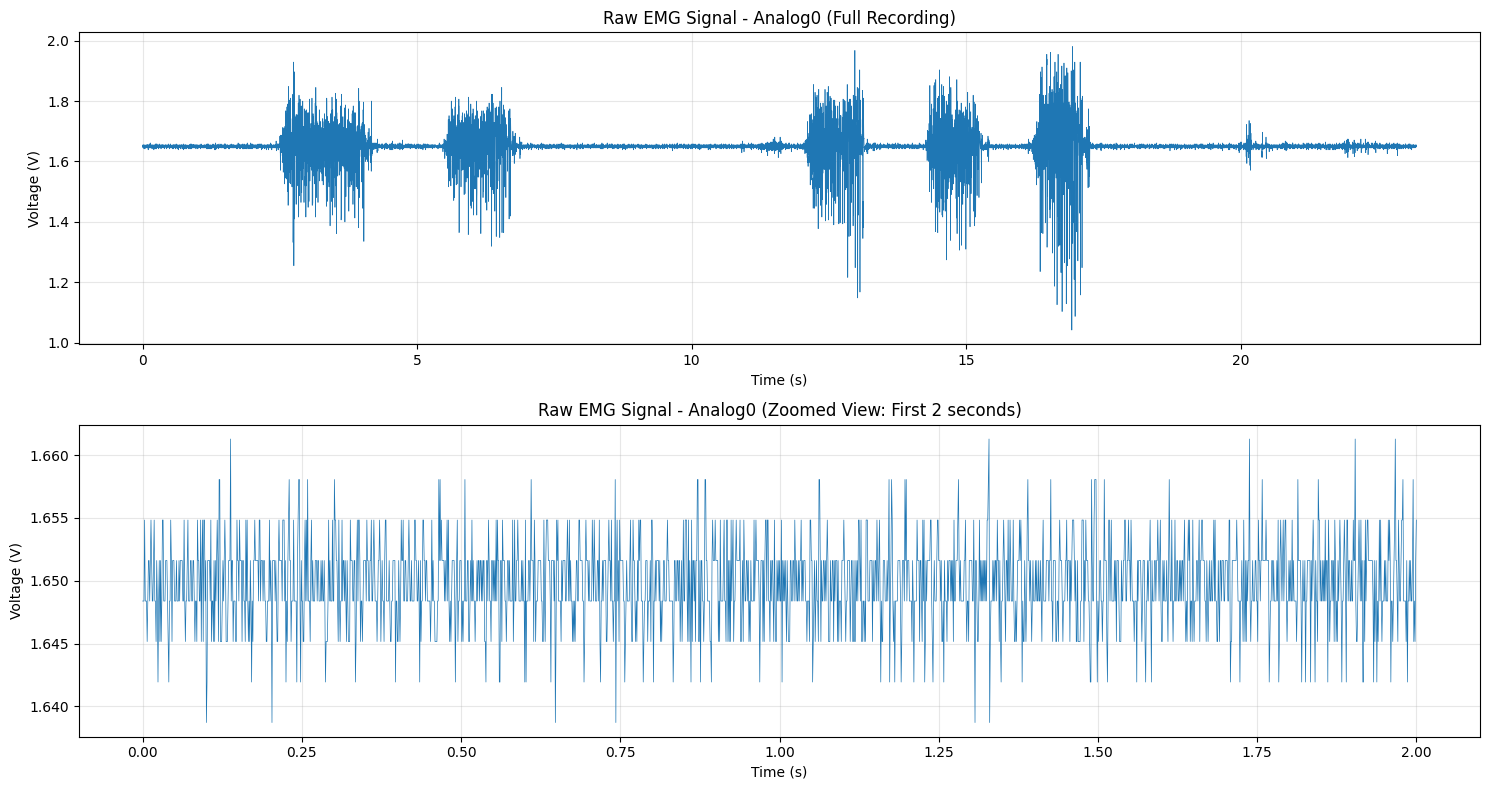

In [68]:
# Plot raw EMG signal
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Full signal
axes[0].plot(timestamps, emg_signal, linewidth=0.5)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Voltage (V)')
axes[0].set_title(f'Raw EMG Signal - {SELECTED_CHANNEL} (Full Recording)')
axes[0].grid(True, alpha=0.3)

# Zoomed view (first 2 seconds)
zoom_end = min(2.0, duration)
zoom_mask = timestamps <= zoom_end
axes[1].plot(timestamps[zoom_mask], emg_signal[zoom_mask], linewidth=0.5)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Voltage (V)')
axes[1].set_title(f'Raw EMG Signal - {SELECTED_CHANNEL} (Zoomed View: First 2 seconds)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Configuration Parameters

Set all adjustable parameters for signal processing in one place

In [69]:
# ==================== FILTER PARAMETERS ====================
# Bandpass filter
BANDPASS_LOW = 20      # Hz - lower cutoff frequency
BANDPASS_HIGH = 450    # Hz - upper cutoff frequency
BANDPASS_ORDER = 4     # Filter order

# Notch filter
NOTCH_FREQ = 60        # Hz - frequency to remove (powerline interference)
NOTCH_QUALITY = 30     # Quality factor

# Envelope filter
ENVELOPE_CUTOFF = 5.0  # Hz - low-pass filter cutoff for envelope extraction

# ==================== FEATURE EXTRACTION PARAMETERS ====================
# RMS/MAV window size
WINDOW_SIZE_MS = 200   # milliseconds - time window for RMS/MAV calculation

# ==================== CONTRACTION DETECTION PARAMETERS ====================
# Rate-of-change detection method
# ADJUSTED FOR BITALINO: Higher voltage signals need lower thresholds
RATE_THRESHOLD = 0.005      # V/s - threshold for detecting contraction onset/offset
                               # Original: 0.0005 (too low for BITalino filtered signals)
                               # Reduced by 10x for better sensitivity
MIN_CONTRACTION_DURATION = 0.3  # seconds - minimum duration for valid contraction
                                # Increased to 0.3s to filter out noise/artifacts

# Spike robustness parameters (NEW)
SMOOTHING_WINDOW = 5        # samples - smoothing window for rate of change (reduces spike sensitivity)
                            # Higher values = more smoothing, less sensitive to quick spikes
                            # Recommended: 3-7 samples
HYSTERESIS_FACTOR = 0.5     # ratio - offset threshold as fraction of onset threshold
                            # Lower values = harder to trigger offset (more robust to spikes)
                            # Recommended: 0.4-0.7 (0.5 = offset needs half the rate change)
MERGE_GAP_SECONDS = None    # seconds - merge contractions separated by less than this
                            # None = auto (50% of MIN_CONTRACTION_DURATION)
                            # Helps rejoin contractions split by spikes

# Threshold-based detection (fallback method)
BASELINE_SAMPLES_PERCENT = 0.15  # Use first 15% of data as baseline (was 10%)
THRESHOLD_FACTOR = 2.0           # Multiplier for baseline std (increased from 1.5)

# ==================== FATIGUE ANALYSIS PARAMETERS ====================
RMS_FATIGUE_THRESHOLD = 3.0    # Sensitivity for RMS rate of change (31.7% increase during fatigue)
MF_FATIGUE_THRESHOLD = -0.5    # Hz/sec decline threshold for median frequency (-0.89 Hz/sec during fatigue)

# ==================== FFT VISUALIZATION PARAMETERS ====================
FFT_MAX_FREQ = None    # Maximum frequency to display in FFT plots (Hz)
                       # Set to None to auto-calculate based on sampling rate (Nyquist frequency)
                       # Recommended values: 500 (for typical EMG), 250 (focus on main EMG band)

print("✓ Configuration parameters loaded")
print(f"  Bandpass: {BANDPASS_LOW}-{BANDPASS_HIGH} Hz")
print(f"  Notch: {NOTCH_FREQ} Hz")
print(f"  RMS window: {WINDOW_SIZE_MS} ms")
print(f"  Contraction rate threshold: {RATE_THRESHOLD} V/s (ADJUSTED FOR BITALINO)")
print(f"  Min contraction duration: {MIN_CONTRACTION_DURATION} s")
print(f"  Spike robustness: smoothing={SMOOTHING_WINDOW} samples, hysteresis={HYSTERESIS_FACTOR}")
print(f"  FFT display range: 0-{FFT_MAX_FREQ if FFT_MAX_FREQ else 'Auto (Nyquist)'} Hz")


✓ Configuration parameters loaded
  Bandpass: 20-450 Hz
  Notch: 60 Hz
  RMS window: 200 ms
  Contraction rate threshold: 0.005 V/s (ADJUSTED FOR BITALINO)
  Min contraction duration: 0.3 s
  Spike robustness: smoothing=5 samples, hysteresis=0.5
  FFT display range: 0-Auto (Nyquist) Hz


## Define All Processing Functions

In [70]:
# ==================== FILTER FUNCTIONS ====================

def butter_bandpass(data, low, high, fs, order=4):
    """Apply Butterworth bandpass filter"""
    nyquist = fs / 2  # Nyquist frequency
    b, a = butter(order, [low/nyquist, high/nyquist], btype="band")
    return filtfilt(b, a, data)

def notch(data, freq, fs, quality=30):
    """Apply notch filter to remove specific frequency (e.g., 60 Hz powerline)"""
    nyquist = fs / 2
    bandwidth = freq / quality
    b, a = butter(2, [(freq-bandwidth/2)/nyquist, (freq+bandwidth/2)/nyquist], btype="bandstop")
    return filtfilt(b, a, data)

def rectify(data):
    """Full-wave rectification"""
    return abs(data)

def envelope(data, fs, cutoff=5.0):
    """Extract envelope using rectification + low-pass filter"""
    nyquist = fs / 2
    b, a = butter(4, cutoff/nyquist, btype="low")
    return filtfilt(b, a, abs(data))

# ==================== FEATURE FUNCTIONS ====================

def rms(data):
    """Calculate Root Mean Square"""
    return np.sqrt(np.mean(data**2, axis=1, keepdims=True))

def mav(data):
    """Calculate Mean Absolute Value"""
    return np.mean(np.abs(data), axis=1, keepdims=True)

def averaged_channels(data):
    """Average across all channels"""
    return np.mean(data, axis=0, keepdims=True).T

def first_contraction_indices(rms_data, baseline_samples=200, threshold_factor=2):
    """
    Find the start and end indices of the first contraction in an RMS array.

    Parameters:
    - rms_data: numpy array of RMS values
    - baseline_samples: number of initial samples to compute baseline
    - threshold_factor: multiplier of baseline std to set threshold

    Returns:
    - start_idx, end_idx: indices of the first contraction (None, None if none found)
    """
    # Compute baseline RMS from first few samples
    baseline_mean = np.mean(rms_data[:baseline_samples])
    baseline_std = np.std(rms_data[:baseline_samples])
    
    # Set threshold
    threshold = baseline_mean + threshold_factor * baseline_std
    
    # Boolean mask for above-threshold
    above_thresh = rms_data > threshold
    
    # Find first contraction
    in_contraction = False
    start_idx, end_idx = None, None
    for i, val in enumerate(above_thresh):
        if val and not in_contraction:
            start_idx = i
            in_contraction = True
        elif not val and in_contraction:
            end_idx = i
            break  # only want the first contraction
    
    # Handle case if contraction goes till the end
    if in_contraction and end_idx is None:
        end_idx = len(rms_data) - 1
    
    return start_idx, end_idx

def calculate_baseline(data):
    """Calculate baseline from pre-contraction period"""
    start_i, end_i = first_contraction_indices(data, baseline_samples=3, threshold_factor=1.5)
    baseline = np.mean(data[start_i:end_i]) if start_i is not None and end_i is not None else np.mean(data[:200])
    return baseline

def detect_contractions_rms_rate(rms_data, fs, rate_threshold=0.001, min_duration_samples=5, 
                                 smoothing_window=3, hysteresis_factor=0.6, merge_gap_samples=None):
    """
    Detect muscle contractions based on rate of change in RMS with improved robustness to spikes.
    
    Parameters:
    - rms_data: numpy array of RMS values
    - fs: effective sampling frequency of the RMS data (e.g., fs/window_size)
    - rate_threshold: threshold for rate of change (V/s) to detect contraction onset
    - min_duration_samples: minimum number of samples for a valid contraction
    - smoothing_window: window size for smoothing rate of change (reduces spike sensitivity)
    - hysteresis_factor: offset threshold = hysteresis_factor * rate_threshold (0.5-0.8 recommended)
    - merge_gap_samples: merge contractions separated by fewer samples (None = auto: 0.5 * min_duration)
    
    Returns:
    - contractions: list of tuples (start_time, end_time, peak_rms) for each detected contraction
    """
    # Calculate rate of change of RMS
    drms_dt = np.gradient(rms_data, 1/fs)
    
    # Smooth the rate of change to reduce sensitivity to spikes
    if smoothing_window > 1:
        # Use a moving average to smooth drms_dt
        kernel = np.ones(smoothing_window) / smoothing_window
        drms_dt_smooth = np.convolve(drms_dt, kernel, mode='same')
    else:
        drms_dt_smooth = drms_dt
    
    # Use hysteresis: higher threshold for onset, lower for offset
    onset_threshold = rate_threshold
    offset_threshold = -rate_threshold * hysteresis_factor  # Less negative, harder to trigger offset
    
    # Detect onset points (positive rate of change above threshold)
    onset_mask = drms_dt_smooth > onset_threshold
    
    # Detect offset points (negative rate of change below offset threshold)
    offset_mask = drms_dt_smooth < offset_threshold
    
    # Find contraction periods with improved robustness
    contractions = []
    in_contraction = False
    start_idx = None
    last_offset_idx = -999  # Track last offset to prevent rapid switching
    refractory_period = max(3, int(min_duration_samples * 0.3))  # 30% of min duration
    
    for i in range(len(rms_data)):
        if onset_mask[i] and not in_contraction:
            # Only start new contraction if enough time passed since last offset
            if i - last_offset_idx > refractory_period:
                start_idx = i
                in_contraction = True
        elif offset_mask[i] and in_contraction:
            # Contraction offset detected
            end_idx = i
            duration = end_idx - start_idx
            
            # Only include if duration meets minimum requirement
            if duration >= min_duration_samples:
                start_time = start_idx / fs
                end_time = end_idx / fs
                peak_rms = np.max(rms_data[start_idx:end_idx])
                contractions.append((start_time, end_time, peak_rms))
                last_offset_idx = i
            
            in_contraction = False
            start_idx = None
    
    # Handle case where contraction extends to end of signal
    if in_contraction and start_idx is not None:
        duration = len(rms_data) - start_idx
        if duration >= min_duration_samples:
            start_time = start_idx / fs
            end_time = (len(rms_data) - 1) / fs
            peak_rms = np.max(rms_data[start_idx:])
            contractions.append((start_time, end_time, peak_rms))
    
    # Merge nearby contractions (likely caused by spikes splitting one contraction)
    if len(contractions) > 1:
        if merge_gap_samples is None:
            merge_gap_samples = max(3, int(min_duration_samples * 0.5))
        
        merged = []
        current_start, current_end, current_peak = contractions[0]
        
        for i in range(1, len(contractions)):
            next_start, next_end, next_peak = contractions[i]
            gap_time = next_start - current_end
            gap_samples = int(gap_time * fs)
            
            if gap_samples <= merge_gap_samples:
                # Merge with current contraction
                current_end = next_end
                # Find peak in merged region
                start_idx = int(current_start * fs)
                end_idx = int(current_end * fs)
                current_peak = np.max(rms_data[start_idx:end_idx])
            else:
                # Save current and start new
                merged.append((current_start, current_end, current_peak))
                current_start, current_end, current_peak = next_start, next_end, next_peak
        
        # Add the last contraction
        merged.append((current_start, current_end, current_peak))
        contractions = merged
    
    return contractions

def activation_timing_post(rms_data, fs, baseline_threshold):
    """Return time points where RMS exceeds baseline threshold"""
    rms_arr = np.ravel(np.asarray(rms_data))
    t_rms = np.arange(len(rms_arr)) / fs
    mask = rms_arr > baseline_threshold
    return t_rms[mask]

def time_to_fatigue_post(rec_data, notch_data, fs, rms_threshold, mf_threshold):
    """
    Calculate time to fatigue based on RMS and median frequency.
    
    Monitor changes in RMS (increases as fatigue progresses due to increased motor unit recruitment ~20-30%)
    and median frequency (MF) (decreases as fatigue progresses due to slowing of muscle fiber conduction velocity).
    
    Parameters:
    - rec_data: rectified/filtered EMG signal
    - notch_data: notch-filtered EMG signal for frequency analysis
    - fs: sampling frequency
    - rms_threshold: sensitivity for RMS rate of change (31.7% increase in non-athletes during fatigue)
    - mf_threshold: Hz/sec decline threshold for median frequency (-0.89 Hz/sec decline during fatigue)
    
    Returns:
    - time_to_rms_fatigue: time array of RMS fatigue onset points (or None)
    - time_to_mf_fatigue: time array of MF fatigue onset points (or None)
    """
    # RMS array calculation
    window_size = 200
    rms_data = np.sqrt(np.convolve(rec_data**2, np.ones(window_size)/window_size, mode='valid'))
    t_rms = np.arange(len(rms_data)) / fs  # time vector for rms
    
    # Determine baseline contraction rms
    baseline_rms = calculate_baseline(rms_data)
    
    # RMS rate of change
    rms_threshold_value = baseline_rms * 1/rms_threshold
    drms = np.gradient(rms_data, 1/fs) 
    rms_indices = np.where(drms > rms_threshold_value)
    
    # Handle empty array case
    if len(rms_indices[0]) > 0:
        time_to_rms_fatigue = t_rms[rms_indices[0]]  # First occurrence
    else:
        time_to_rms_fatigue = None

    # Median frequency calculation with improved implementation
    nperseg = 256
    noverlap = nperseg - 50  # Using overlap for cleaner implementation
    
    f, t_spec, Sxx = spectrogram(notch_data, fs=fs, nperseg=nperseg, noverlap=noverlap)
    
    # Calculate median frequency for each time window
    median_freqs = []
    for i in range(Sxx.shape[1]):
        psd = Sxx[:, i]
        cumsum = np.cumsum(psd)
        cumsum /= cumsum[-1]  # normalize
        mf = np.interp(0.5, cumsum, f)
        median_freqs.append(mf)
    
    median_freqs = np.array(median_freqs)
    times = t_spec

    # Rate of change of median frequency
    dmf = np.gradient(median_freqs, np.mean(np.diff(times)))
    mf_indices = np.where(dmf < mf_threshold)

    # Handle empty array case
    if len(mf_indices[0]) > 0:
        time_to_mf_fatigue = times[mf_indices[0]]  # First occurrence
    else:
        time_to_mf_fatigue = None

    return time_to_rms_fatigue, time_to_mf_fatigue

# ==================== TRANSFORM FUNCTIONS ====================

def fft_transform(data):
    """Apply FFT transform"""
    return np.abs(np.fft.rfft(data, axis=1))

# ==================== PROCESSING PIPELINES ====================

def process_filtered(data, fs):
    """Apply bandpass filter + notch filter (uses config parameters)"""
    bandpassed = butter_bandpass(data, low=BANDPASS_LOW, high=BANDPASS_HIGH, fs=fs, order=BANDPASS_ORDER)
    filtered = notch(bandpassed, freq=NOTCH_FREQ, fs=fs, quality=NOTCH_QUALITY)
    return filtered

def process_rectified(data):
    """Apply full-wave rectification"""
    return rectify(data)

def process_envelope(data, fs):
    """Apply envelope detection (rectify + low-pass filter)"""
    return envelope(data, fs=fs, cutoff=ENVELOPE_CUTOFF)

def process_fft(data):
    """Apply FFT transform"""
    if data.ndim == 1:
        data = data.reshape(1, -1)
    return fft_transform(data)

print("✓ All processing functions defined (CORRECTED FILTER NORMALIZATION):")
print("  Filters: butter_bandpass, notch, rectify, envelope")
print("  Features: rms, mav, averaged_channels, calculate_baseline, detect_contractions_rms_rate, activation_timing_post, time_to_fatigue_post")
print("  Transforms: fft_transform")
print("  Pipelines: process_filtered, process_rectified, process_envelope, process_fft")

✓ All processing functions defined (CORRECTED FILTER NORMALIZATION):
  Filters: butter_bandpass, notch, rectify, envelope
  Features: rms, mav, averaged_channels, calculate_baseline, detect_contractions_rms_rate, activation_timing_post, time_to_fatigue_post
  Transforms: fft_transform
  Pipelines: process_filtered, process_rectified, process_envelope, process_fft


## Apply Filtering Pipeline

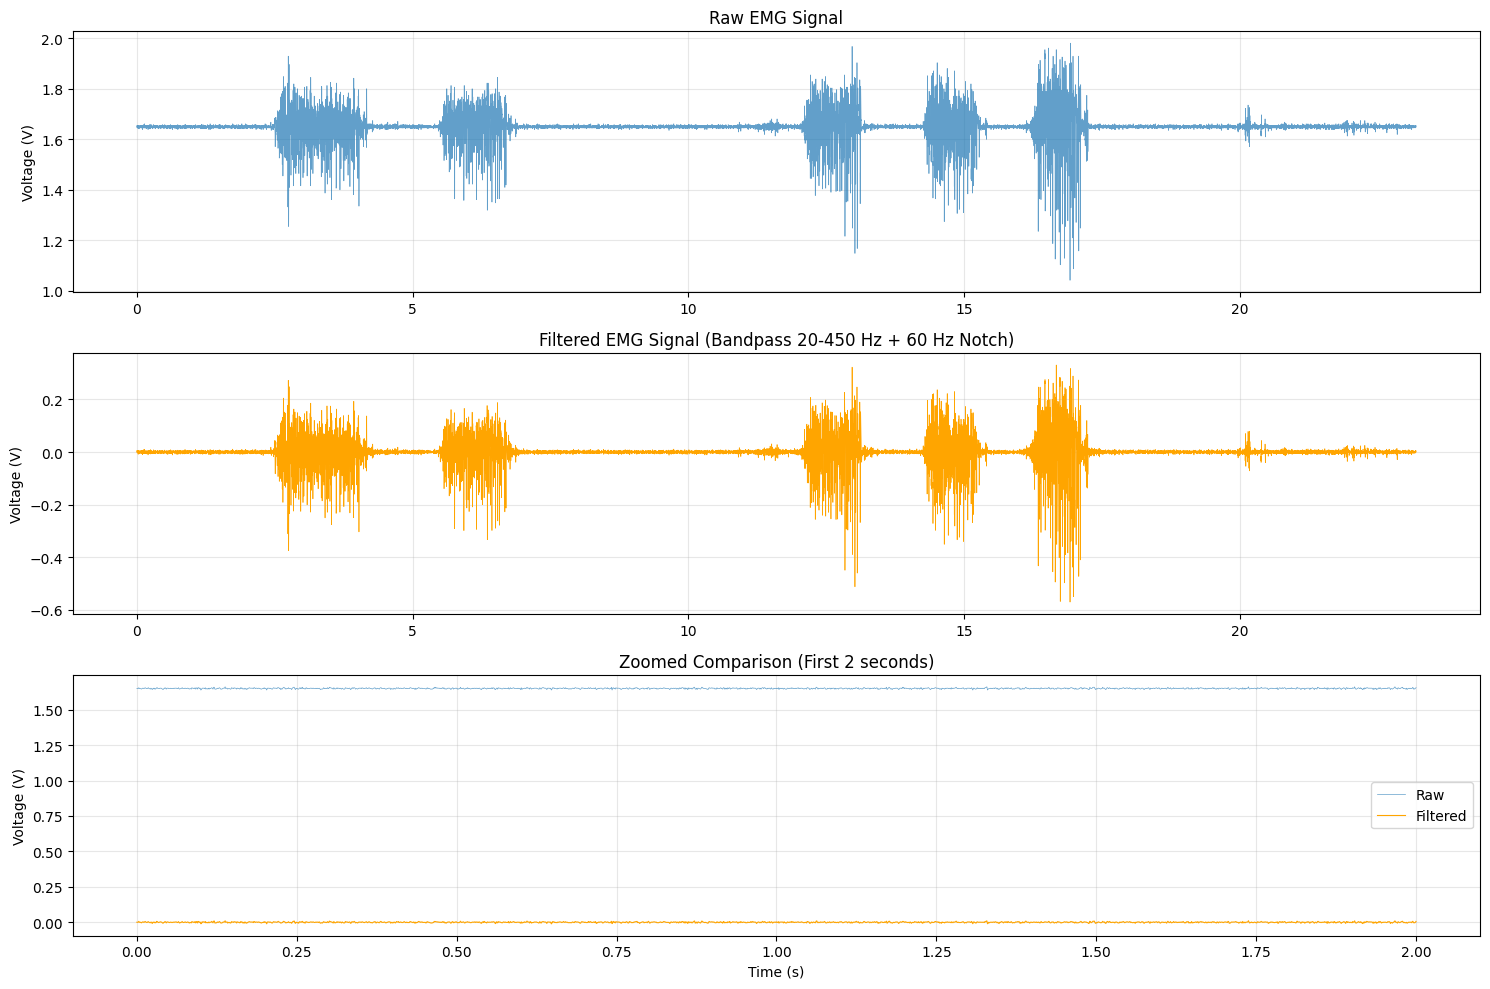

Raw signal: min=1.041935 V, max=1.980645 V, std=0.050556 V
Filtered signal: min=-0.571268 V, max=0.331353 V, std=0.049683 V


In [71]:
# Apply filtered processing
raw_signal = emg_signal
filtered_signal = process_filtered(raw_signal, fs)

# Plot comparison
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Raw signal
axes[0].plot(timestamps, raw_signal, linewidth=0.5, alpha=0.7)
axes[0].set_ylabel('Voltage (V)')
axes[0].set_title('Raw EMG Signal')
axes[0].grid(True, alpha=0.3)

# Filtered signal
axes[1].plot(timestamps, filtered_signal, linewidth=0.5, color='orange')
axes[1].set_ylabel('Voltage (V)')
axes[1].set_title(f'Filtered EMG Signal (Bandpass 20-450 Hz + 60 Hz Notch)')
axes[1].grid(True, alpha=0.3)

# Zoomed comparison (first 2 seconds)
zoom_end = min(2.0, duration)
zoom_mask = timestamps <= zoom_end
axes[2].plot(timestamps[zoom_mask], raw_signal[zoom_mask], linewidth=0.5, alpha=0.7, label='Raw')
axes[2].plot(timestamps[zoom_mask], filtered_signal[zoom_mask], linewidth=0.8, color='orange', label='Filtered')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Voltage (V)')
axes[2].set_title('Zoomed Comparison (First 2 seconds)')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"Raw signal: min={raw_signal.min():.6f} V, max={raw_signal.max():.6f} V, std={raw_signal.std():.6f} V")
print(f"Filtered signal: min={filtered_signal.min():.6f} V, max={filtered_signal.max():.6f} V, std={filtered_signal.std():.6f} V")

## Apply Rectified & Envelope Pipelines

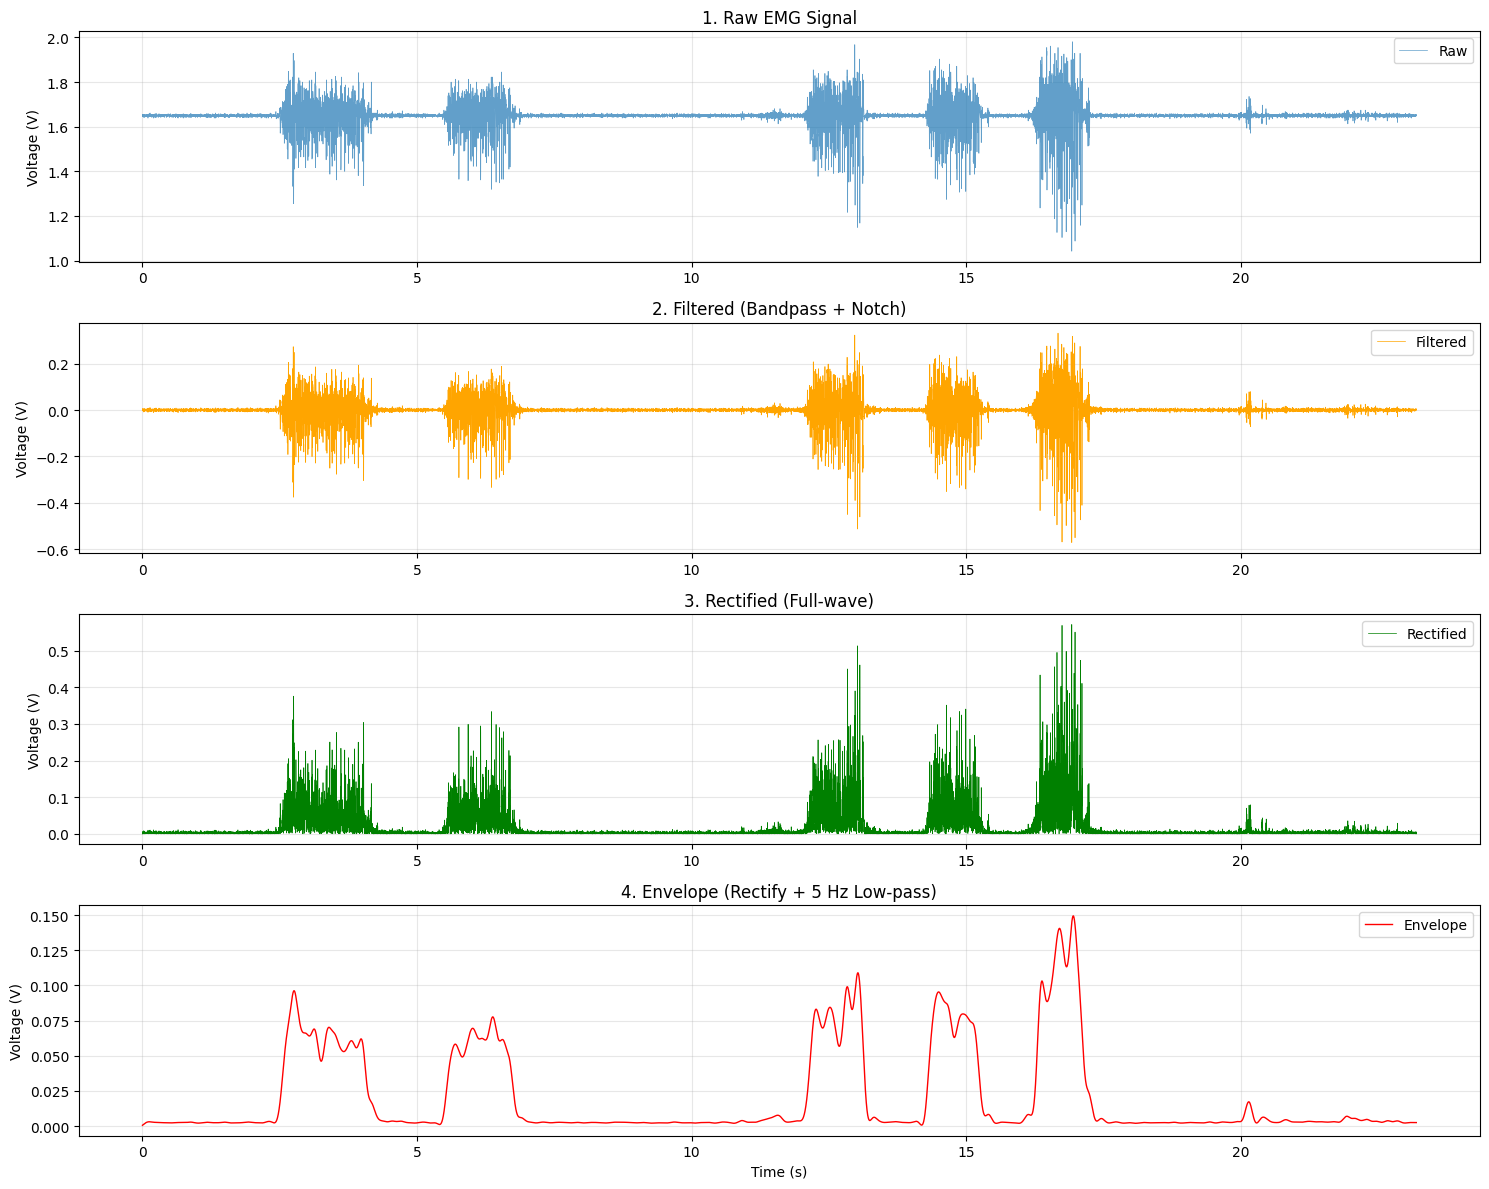

In [72]:
# Apply all processing steps
rectified_signal = process_rectified(filtered_signal)
envelope_signal = process_envelope(filtered_signal, fs)

# Plot all processing stages
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Raw
axes[0].plot(timestamps, raw_signal, linewidth=0.5, alpha=0.7, label='Raw')
axes[0].set_ylabel('Voltage (V)')
axes[0].set_title('1. Raw EMG Signal')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Filtered
axes[1].plot(timestamps, filtered_signal, linewidth=0.5, color='orange', label='Filtered')
axes[1].set_ylabel('Voltage (V)')
axes[1].set_title('2. Filtered (Bandpass + Notch)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Rectified
axes[2].plot(timestamps, rectified_signal, linewidth=0.5, color='green', label='Rectified')
axes[2].set_ylabel('Voltage (V)')
axes[2].set_title('3. Rectified (Full-wave)')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

# Envelope
axes[3].plot(timestamps, envelope_signal, linewidth=1, color='red', label='Envelope')
axes[3].set_xlabel('Time (s)')
axes[3].set_ylabel('Voltage (V)')
axes[3].set_title('4. Envelope (Rectify + 5 Hz Low-pass)')
axes[3].grid(True, alpha=0.3)
axes[3].legend()

plt.tight_layout()
plt.show()

## Extract EMG Features (RMS, MAV)

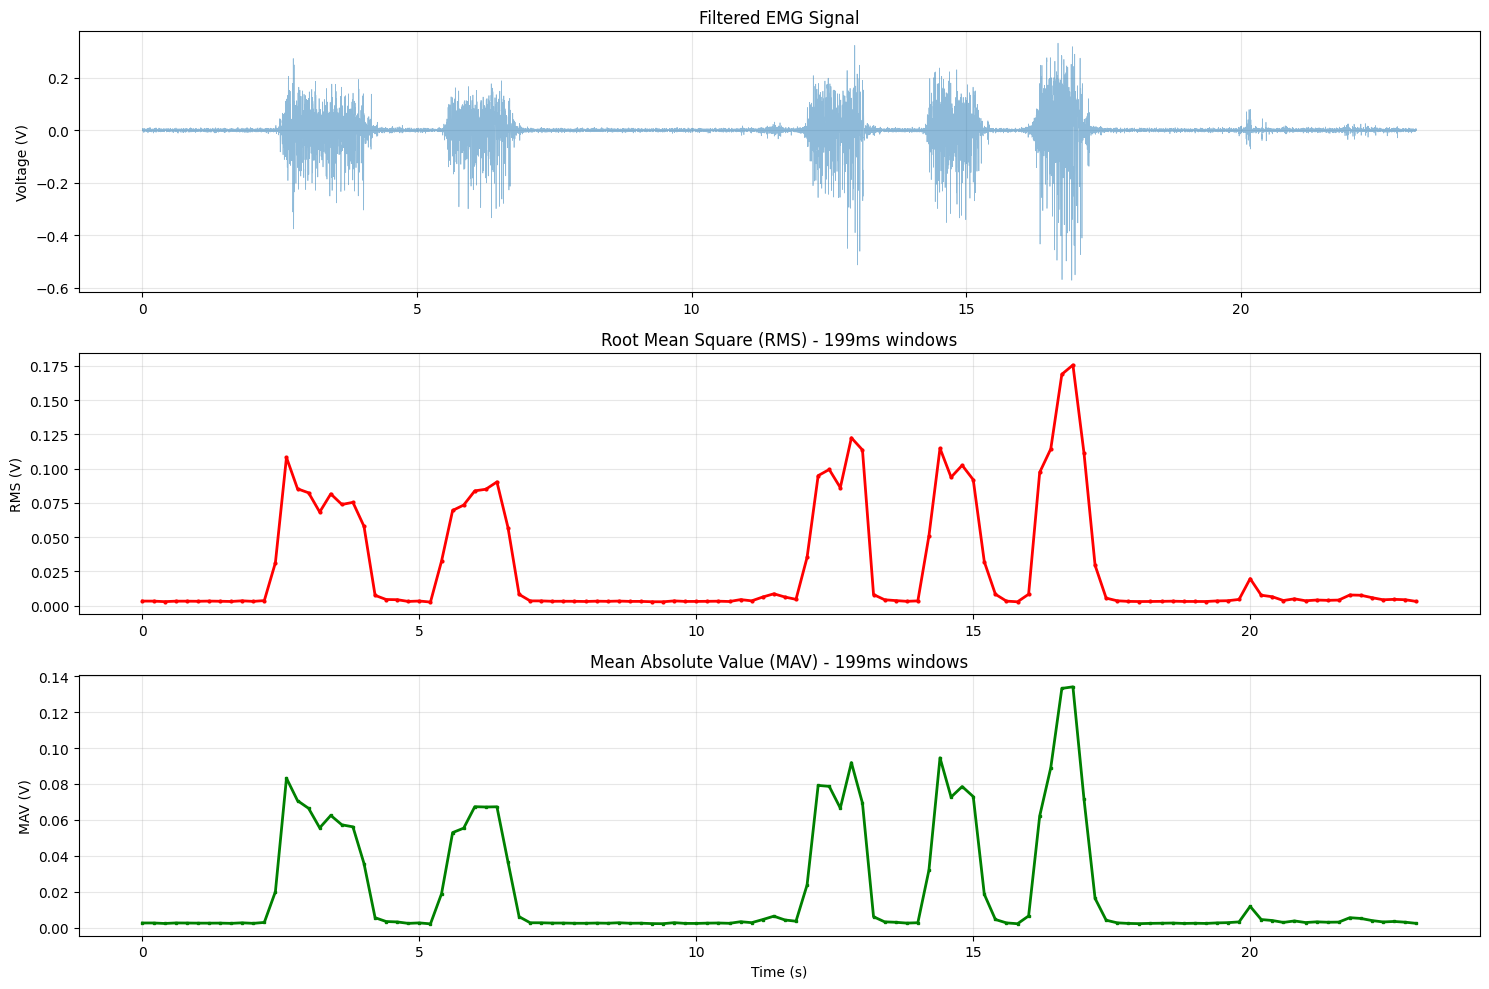

RMS: min=0.002575 V, max=0.175610 V, mean=0.027916 V
MAV: min=0.002094 V, max=0.134126 V, mean=0.020863 V


In [73]:
# Calculate RMS in windows
window_size = int((WINDOW_SIZE_MS / 1000) * fs)  # Convert ms to samples
n_windows = len(filtered_signal) // window_size
filtered_windows = filtered_signal[:n_windows * window_size].reshape(n_windows, window_size)

# Calculate RMS for each window
rms_values = rms(filtered_windows).flatten()
rms_times = np.arange(n_windows) * window_size / fs

# Calculate MAV for each window
mav_values = mav(filtered_windows).flatten()

# Plot RMS and MAV
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Filtered signal
axes[0].plot(timestamps, filtered_signal, linewidth=0.5, alpha=0.5)
axes[0].set_ylabel('Voltage (V)')
axes[0].set_title('Filtered EMG Signal')
axes[0].grid(True, alpha=0.3)

# RMS
axes[1].plot(rms_times, rms_values, linewidth=2, color='red', marker='o', markersize=2)
axes[1].set_ylabel('RMS (V)')
axes[1].set_title(f'Root Mean Square (RMS) - {int(window_size/fs*1000)}ms windows')
axes[1].grid(True, alpha=0.3)

# MAV
axes[2].plot(rms_times, mav_values, linewidth=2, color='green', marker='s', markersize=2)
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('MAV (V)')
axes[2].set_title(f'Mean Absolute Value (MAV) - {int(window_size/fs*1000)}ms windows')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"RMS: min={rms_values.min():.6f} V, max={rms_values.max():.6f} V, mean={rms_values.mean():.6f} V")
print(f"MAV: min={mav_values.min():.6f} V, max={mav_values.max():.6f} V, mean={mav_values.mean():.6f} V")

## FFT Analysis (Frequency Domain)

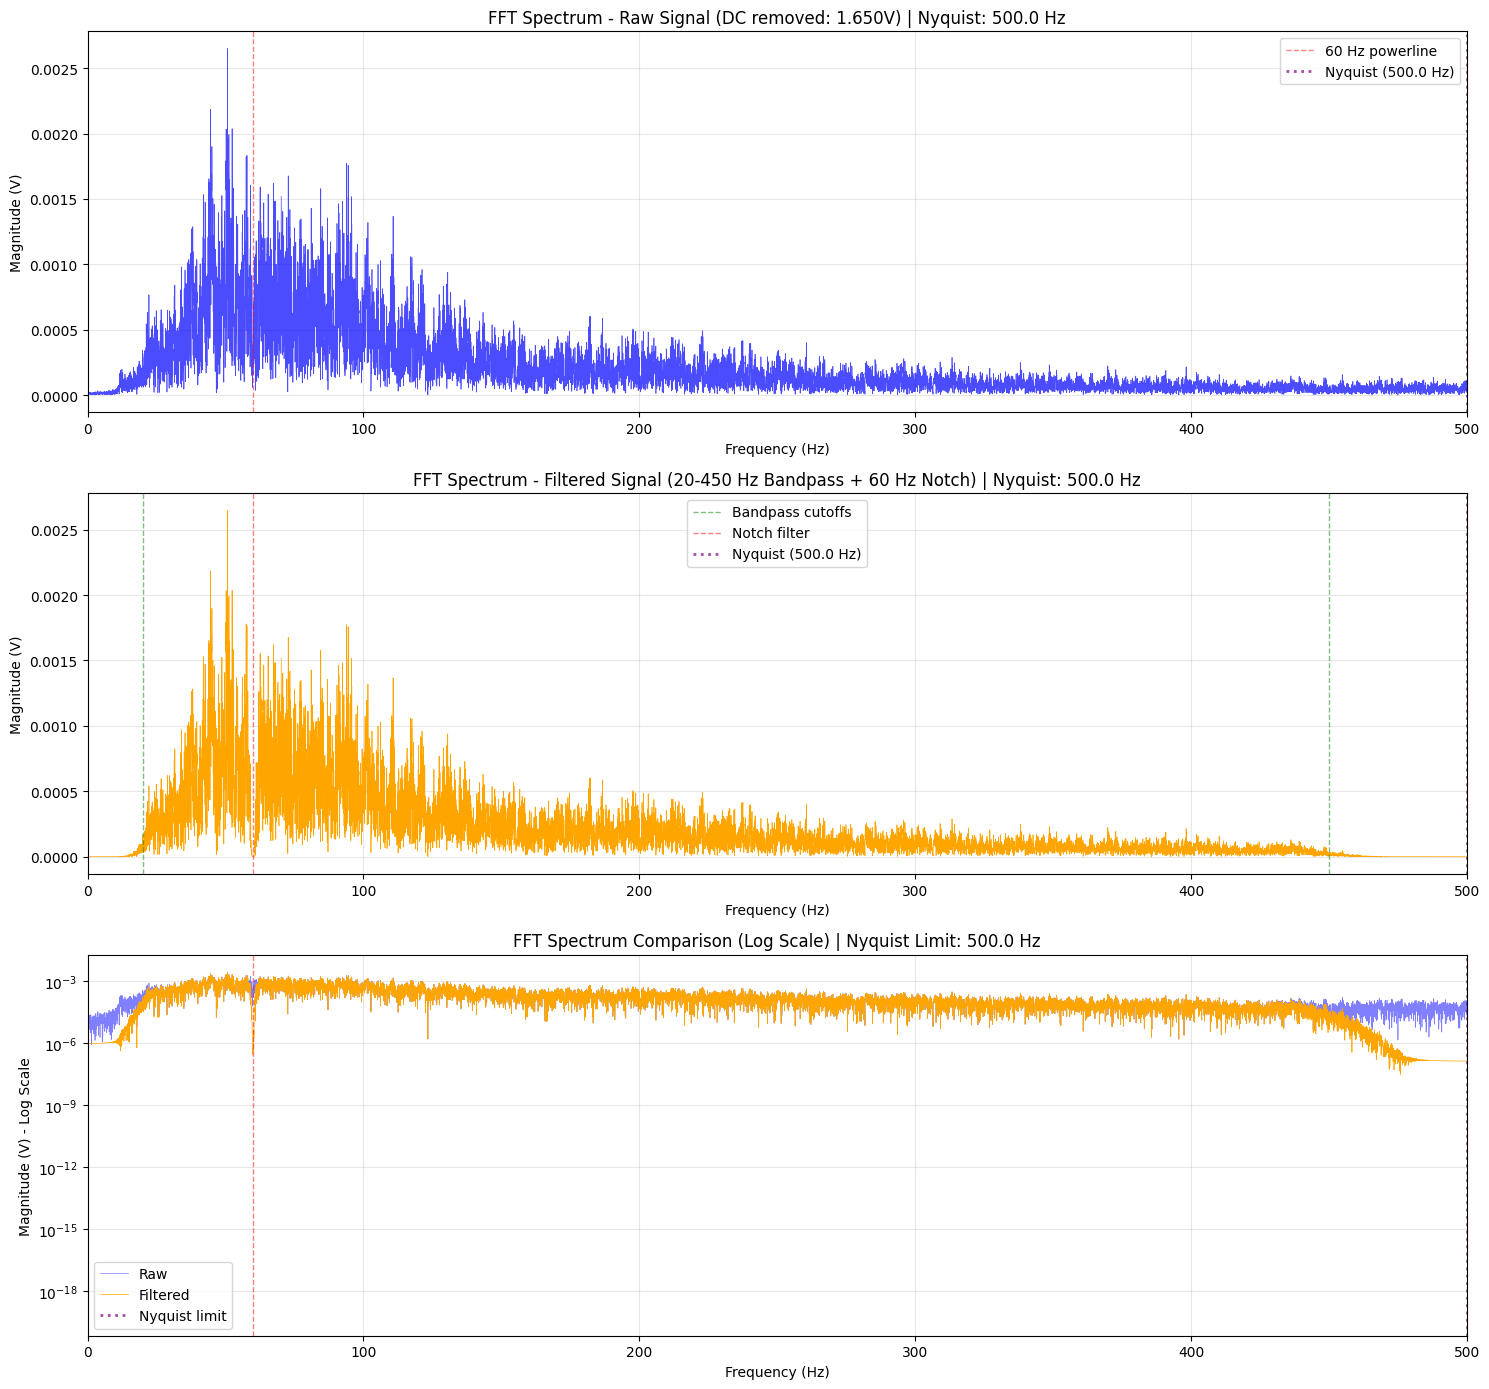

Signal characteristics:
  Sampling rate: 1000.0 Hz
  Nyquist frequency: 500.0 Hz (max representable frequency)
  FFT display range: 0-500.0 Hz
  Raw signal DC offset: 1.650 V (typical for BITalino: ~1.65V)
  Filtered signal DC: 0.000001 V (removed by filtering)

Top 5 dominant frequencies in filtered EMG range (20-450 Hz):
  1. 50.7 Hz - Magnitude: 0.002648 V
  2. 44.6 Hz - Magnitude: 0.002182 V
  3. 52.4 Hz - Magnitude: 0.002036 V
  4. 50.3 Hz - Magnitude: 0.002032 V
  5. 51.3 Hz - Magnitude: 0.001991 V

60 Hz powerline interference:
  Raw signal: 0.000155 V
  Filtered signal: 0.000000 V (reduction: 99.7%)

Note: The 'cutoff' at 500.0 Hz is the Nyquist limit, not signal attenuation.
      No frequencies above 500.0 Hz can be represented at 1000.0 Hz sampling rate.


In [74]:
# Analyze frequency content using proper FFT
# Remove DC offset from both signals
filtered_signal_no_dc = filtered_signal - np.mean(filtered_signal)
emg_signal_no_dc = emg_signal - np.mean(emg_signal)

# Compute FFT manually (avoiding the process_fft function which has wrong axis)
fft_filtered = np.fft.rfft(filtered_signal_no_dc)
fft_raw = np.fft.rfft(emg_signal_no_dc)

# Normalize by signal length and convert to magnitude
fft_filtered_mag = np.abs(fft_filtered) / len(filtered_signal_no_dc)
fft_raw_mag = np.abs(fft_raw) / len(emg_signal_no_dc)

# Create frequency axis
freqs_filtered = np.fft.rfftfreq(len(filtered_signal_no_dc), 1/fs)
freqs_raw = np.fft.rfftfreq(len(emg_signal_no_dc), 1/fs)

# Determine FFT display range based on configuration
nyquist_freq = fs / 2
if FFT_MAX_FREQ is None:
    fft_display_max = nyquist_freq
else:
    fft_display_max = min(FFT_MAX_FREQ, nyquist_freq)

# Plot FFT with 3 subplots: raw, filtered, and log scale comparison
fig, axes = plt.subplots(3, 1, figsize=(15, 14))

# Raw signal spectrum (DC removed)
axes[0].plot(freqs_raw, fft_raw_mag, linewidth=0.5, color='blue', alpha=0.7)
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Magnitude (V)')
axes[0].set_title(f'FFT Spectrum - Raw Signal (DC removed: {np.mean(emg_signal):.3f}V) | Nyquist: {nyquist_freq:.1f} Hz')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, fft_display_max])
axes[0].axvline(x=60, color='r', linestyle='--', linewidth=1, alpha=0.5, label='60 Hz powerline')
axes[0].axvline(x=nyquist_freq, color='purple', linestyle=':', linewidth=2, alpha=0.7, label=f'Nyquist ({nyquist_freq:.1f} Hz)')
axes[0].legend()

# Filtered signal spectrum
axes[1].plot(freqs_filtered, fft_filtered_mag, linewidth=0.5, color='orange')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Magnitude (V)')
axes[1].set_title(f'FFT Spectrum - Filtered Signal (20-450 Hz Bandpass + 60 Hz Notch) | Nyquist: {nyquist_freq:.1f} Hz')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, fft_display_max])
axes[1].axvline(x=20, color='g', linestyle='--', linewidth=1, alpha=0.5, label='Bandpass cutoffs')
axes[1].axvline(x=450, color='g', linestyle='--', linewidth=1, alpha=0.5)
axes[1].axvline(x=60, color='r', linestyle='--', linewidth=1, alpha=0.5, label='Notch filter')
axes[1].axvline(x=nyquist_freq, color='purple', linestyle=':', linewidth=2, alpha=0.7, label=f'Nyquist ({nyquist_freq:.1f} Hz)')
axes[1].legend()

# Log scale comparison
axes[2].semilogy(freqs_raw, fft_raw_mag, linewidth=0.5, color='blue', alpha=0.5, label='Raw')
axes[2].semilogy(freqs_filtered, fft_filtered_mag, linewidth=0.5, color='orange', label='Filtered')
axes[2].set_xlabel('Frequency (Hz)')
axes[2].set_ylabel('Magnitude (V) - Log Scale')
axes[2].set_title(f'FFT Spectrum Comparison (Log Scale) | Nyquist Limit: {nyquist_freq:.1f} Hz')
axes[2].grid(True, alpha=0.3, which='both')
axes[2].set_xlim([0, fft_display_max])
axes[2].axvline(x=60, color='r', linestyle='--', linewidth=1, alpha=0.5)
axes[2].axvline(x=nyquist_freq, color='purple', linestyle=':', linewidth=2, alpha=0.7, label=f'Nyquist limit')
axes[2].legend()

plt.tight_layout()
plt.show()

# Find dominant frequencies in EMG range (20-450 Hz)
emg_mask = (freqs_filtered >= 20) & (freqs_filtered <= 450)
emg_freqs = freqs_filtered[emg_mask]
emg_fft_mag = fft_filtered_mag[emg_mask]
peak_indices = np.argsort(emg_fft_mag)[-5:][::-1]

print("Signal characteristics:")
print(f"  Sampling rate: {fs:.1f} Hz")
print(f"  Nyquist frequency: {nyquist_freq:.1f} Hz (max representable frequency)")
print(f"  FFT display range: 0-{fft_display_max:.1f} Hz")
print(f"  Raw signal DC offset: {np.mean(emg_signal):.3f} V (typical for BITalino: ~1.65V)")
print(f"  Filtered signal DC: {np.mean(filtered_signal):.6f} V (removed by filtering)")
print(f"\nTop 5 dominant frequencies in filtered EMG range (20-450 Hz):")
for i, idx in enumerate(peak_indices):
    print(f"  {i+1}. {emg_freqs[idx]:.1f} Hz - Magnitude: {emg_fft_mag[idx]:.6f} V")

# Check for powerline interference
powerline_idx = np.argmin(np.abs(freqs_raw - 60))
print(f"\n60 Hz powerline interference:")
print(f"  Raw signal: {fft_raw_mag[powerline_idx]:.6f} V")
print(f"  Filtered signal: {fft_filtered_mag[powerline_idx]:.6f} V (reduction: {(1 - fft_filtered_mag[powerline_idx]/fft_raw_mag[powerline_idx])*100:.1f}%)")

print(f"\nNote: The 'cutoff' at {nyquist_freq:.1f} Hz is the Nyquist limit, not signal attenuation.")
print(f"      No frequencies above {nyquist_freq:.1f} Hz can be represented at {fs:.1f} Hz sampling rate.")


## Activation Timing Detection

First contraction detected: 1.80s to 3.20s
First contraction mean RMS: 0.045305 V
Threshold: 0.022652 V


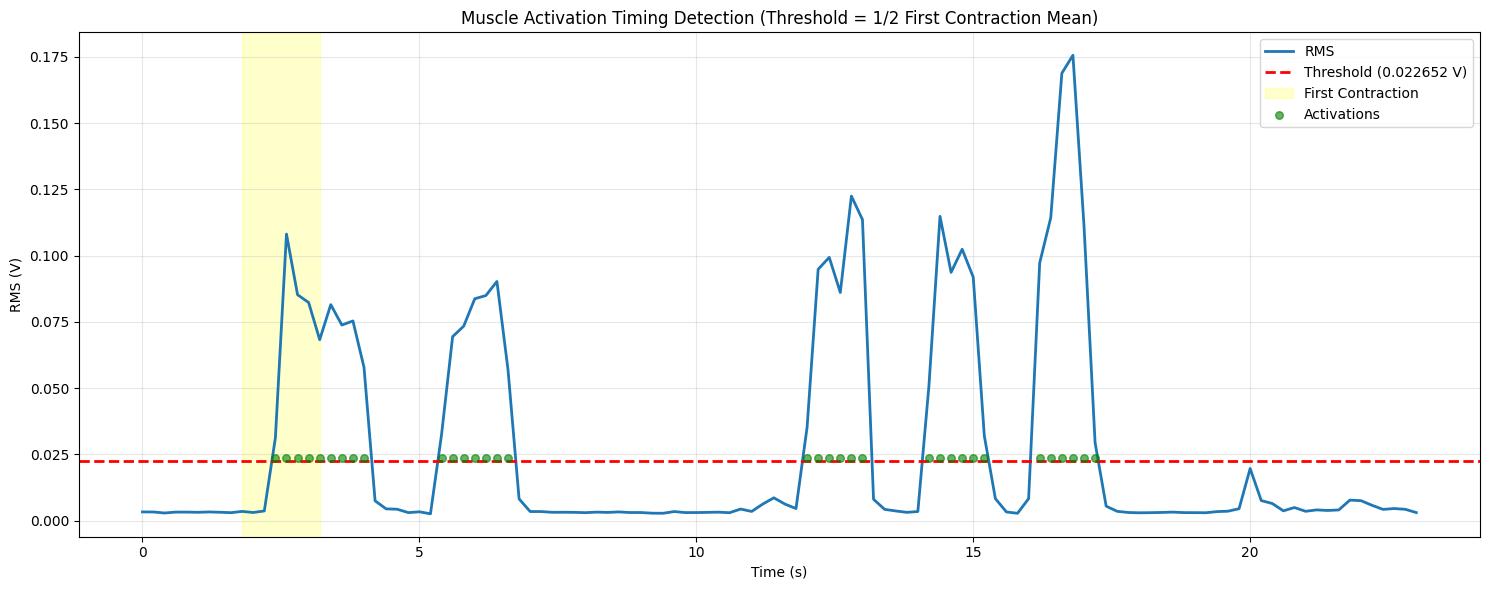

Activation threshold: 0.022652 V
Total activation time points: 34
Activation percentage: 29.3%


In [75]:
# Calculate RMS for activation timing
window_size = int((WINDOW_SIZE_MS / 1000) * fs)  # Convert ms to samples
n_windows = len(filtered_signal) // window_size
filtered_windows = filtered_signal[:n_windows * window_size].reshape(n_windows, window_size)
rms_for_timing = rms(filtered_windows).flatten()
rms_times = np.arange(n_windows) * window_size / fs

# Effective sampling frequency for RMS data
fs_rms = fs / window_size

# Detect contractions using rate-of-change method (from config)
rate_threshold = RATE_THRESHOLD
min_duration = MIN_CONTRACTION_DURATION
min_duration_samples = int(min_duration * fs_rms)
merge_gap_samples = int(MERGE_GAP_SECONDS * fs_rms) if MERGE_GAP_SECONDS else None

contractions = detect_contractions_rms_rate(
    rms_for_timing, 
    fs_rms, 
    rate_threshold=rate_threshold,
    min_duration_samples=min_duration_samples,
    smoothing_window=SMOOTHING_WINDOW,
    hysteresis_factor=HYSTERESIS_FACTOR,
    merge_gap_samples=merge_gap_samples
)

# Use the first detected contraction to establish threshold
if len(contractions) > 0:
    start_t, end_t, peak = contractions[0]
    start_idx = int(start_t * fs_rms)
    end_idx = int(end_t * fs_rms)
    
    # Calculate threshold as 1/2 the mean of RMS values during first contraction
    first_contraction_mean = np.mean(rms_for_timing[start_idx:end_idx])
    threshold = first_contraction_mean / 2
    print(f"First contraction detected: {start_t:.2f}s to {end_t:.2f}s")
    print(f"First contraction mean RMS: {first_contraction_mean:.6f} V")
else:
    # Fallback: use baseline-based threshold if no contraction detected
    baseline_samples = int(len(rms_for_timing) * BASELINE_SAMPLES_PERCENT)
    baseline_rms = np.mean(rms_for_timing[:baseline_samples])
    threshold = baseline_rms * THRESHOLD_FACTOR
    start_idx, end_idx = None, None
    print("No contraction detected using rate-of-change method, using baseline threshold")

print(f"Threshold: {threshold:.6f} V")

# Detect activation times
activation_times = activation_timing_post(rms_for_timing, fs_rms, threshold)

# Plot activation timing
plt.figure(figsize=(15, 6))
plt.plot(rms_times, rms_for_timing, linewidth=2, label='RMS')
plt.axhline(y=threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.6f} V)')
if len(contractions) > 0:
    start_t, end_t, peak = contractions[0]
    # Highlight the first contraction region
    plt.axvspan(start_t, end_t, alpha=0.2, color='yellow', label='First Contraction')
plt.scatter(activation_times, np.ones_like(activation_times) * threshold * 1.05, 
           color='green', s=30, alpha=0.6, label='Activations', zorder=5)
plt.xlabel('Time (s)')
plt.ylabel('RMS (V)')
plt.title('Muscle Activation Timing Detection (Threshold = 1/2 First Contraction Mean)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


print(f"Activation threshold: {threshold:.6f} V")
print(f"Total activation time points: {len(activation_times)}")
print(f"Activation percentage: {len(activation_times) / len(rms_for_timing) * 100:.1f}%")

## Contraction Detection (Rate-of-Change Method)

**Enhanced robustness features:**
- **Smoothing**: Reduces sensitivity to rapid spikes in rate of change
- **Hysteresis**: Uses different thresholds for onset (stricter) vs offset (more lenient) to prevent premature termination
- **Refractory period**: Prevents rapid on/off switching from noise
- **Contraction merging**: Rejoins contractions that were split by brief spikes

Adjust `SMOOTHING_WINDOW`, `HYSTERESIS_FACTOR`, and `MERGE_GAP_SECONDS` in the configuration cell to tune robustness

Detected 6 contractions:
  Contraction 1: 1.80s - 3.20s (duration: 1.40s, peak RMS: 0.108137V)
  Contraction 2: 4.80s - 6.20s (duration: 1.40s, peak RMS: 0.083729V)
  Contraction 3: 11.40s - 12.60s (duration: 1.20s, peak RMS: 0.099343V)
  Contraction 4: 13.80s - 14.80s (duration: 1.00s, peak RMS: 0.114825V)
  Contraction 5: 15.80s - 16.80s (duration: 1.00s, peak RMS: 0.168823V)
  Contraction 6: 19.40s - 20.40s (duration: 1.00s, peak RMS: 0.019660V)


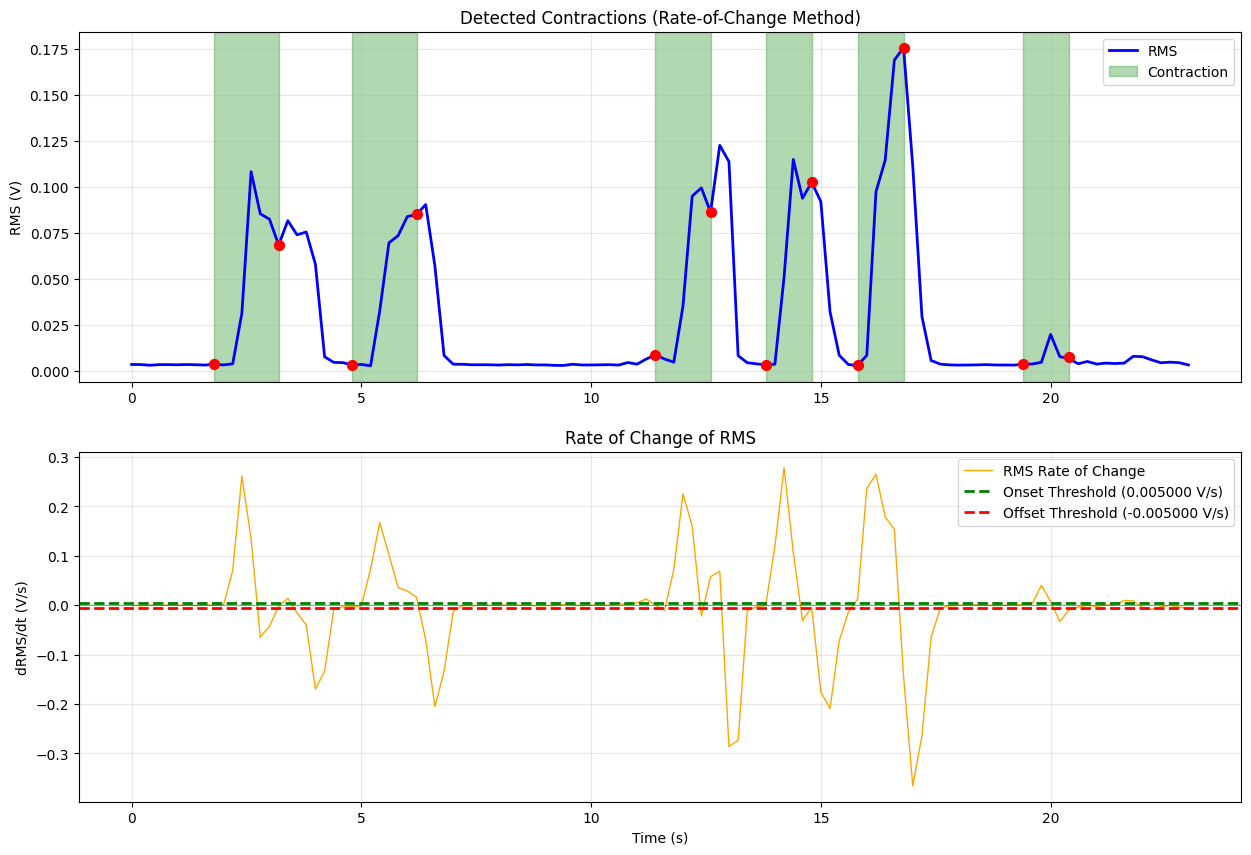

<Figure size 640x480 with 0 Axes>

In [77]:
# Detect contractions using rate of change in RMS
window_size = int((WINDOW_SIZE_MS / 1000) * fs)  # Convert ms to samples
n_windows = len(filtered_signal) // window_size
filtered_windows = filtered_signal[:n_windows * window_size].reshape(n_windows, window_size)
rms_for_detection = rms(filtered_windows).flatten()
rms_times = np.arange(n_windows) * window_size / fs

# Effective sampling frequency for RMS data
fs_rms = fs / window_size

# Detect contractions (using config parameters)
rate_threshold = RATE_THRESHOLD
min_duration = MIN_CONTRACTION_DURATION
min_duration_samples = int(min_duration * fs_rms)
merge_gap_samples = int(MERGE_GAP_SECONDS * fs_rms) if MERGE_GAP_SECONDS else None

contractions = detect_contractions_rms_rate(
    rms_for_detection, 
    fs_rms, 
    rate_threshold=rate_threshold,
    min_duration_samples=min_duration_samples,
    smoothing_window=SMOOTHING_WINDOW,
    hysteresis_factor=HYSTERESIS_FACTOR,
    merge_gap_samples=merge_gap_samples
)

print(f"Detected {len(contractions)} contractions:")
for i, (start_t, end_t, peak) in enumerate(contractions):
    duration = end_t - start_t
    print(f"  Contraction {i+1}: {start_t:.2f}s - {end_t:.2f}s (duration: {duration:.2f}s, peak RMS: {peak:.6f}V)")

# Visualize detected contractions
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# RMS with detected contractions
axes[0].plot(rms_times, rms_for_detection, linewidth=2, label='RMS', color='blue')
for i, (start_t, end_t, peak) in enumerate(contractions):
    axes[0].axvspan(start_t, end_t, alpha=0.3, color='green', label='Contraction' if i == 0 else '')
    axes[0].scatter([start_t, end_t], [rms_for_detection[int(start_t*fs_rms)], rms_for_detection[min(int(end_t*fs_rms), len(rms_for_detection)-1)]], 
                   color='red', s=50, zorder=5)
axes[0].set_ylabel('RMS (V)')
axes[0].set_title('Detected Contractions (Rate-of-Change Method)')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Rate of change of RMS
drms_dt = np.gradient(rms_for_detection, 1/fs_rms)
axes[1].plot(rms_times, drms_dt, linewidth=1, color='orange', label='RMS Rate of Change')
axes[1].axhline(y=rate_threshold, color='g', linestyle='--', linewidth=2, label=f'Onset Threshold ({rate_threshold:.6f} V/s)')
axes[1].axhline(y=-rate_threshold, color='r', linestyle='--', linewidth=2, label=f'Offset Threshold ({-rate_threshold:.6f} V/s)')
axes[1].axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.5)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('dRMS/dt (V/s)')
axes[1].set_title('Rate of Change of RMS')
axes[1].grid(True, alpha=0.3)

axes[1].legend()
plt.show()

plt.tight_layout()

## Contraction Detection Diagnostics

Use this cell to analyze and fine-tune detection parameters

In [ ]:
# Diagnostic analysis to help tune contraction detection parameters
print("=" * 70)
print("CONTRACTION DETECTION DIAGNOSTICS")
print("=" * 70)

# Analyze RMS signal characteristics
print(f"\n1. RMS Signal Statistics:")
print(f"   RMS min: {rms_for_detection.min():.6f} V")
print(f"   RMS max: {rms_for_detection.max():.6f} V")
print(f"   RMS mean: {rms_for_detection.mean():.6f} V")
print(f"   RMS std: {rms_for_detection.std():.6f} V")
print(f"   RMS range: {rms_for_detection.max() - rms_for_detection.min():.6f} V")

# Analyze rate of change
print(f"\n2. Rate of Change Statistics:")
print(f"   dRMS/dt min: {drms_dt.min():.6f} V/s")
print(f"   dRMS/dt max: {drms_dt.max():.6f} V/s")
print(f"   dRMS/dt mean: {drms_dt.mean():.6f} V/s")
print(f"   dRMS/dt std: {drms_dt.std():.6f} V/s")

# Calculate percentiles of rate of change
percentiles = [90, 95, 99]
positive_rates = drms_dt[drms_dt > 0]
negative_rates = drms_dt[drms_dt < 0]

print(f"\n3. Rate of Change Percentiles:")
print(f"   Positive rates:")
for p in percentiles:
    val = np.percentile(positive_rates, p)
    print(f"     {p}th percentile: {val:.6f} V/s")

print(f"   Negative rates:")
for p in percentiles:
    val = np.percentile(negative_rates, p)
    print(f"     {p}th percentile: {val:.6f} V/s")

# Current detection parameters
print(f"\n4. Current Detection Parameters:")
print(f"   RATE_THRESHOLD: {RATE_THRESHOLD:.6f} V/s (onset)")
print(f"   Offset threshold: {RATE_THRESHOLD * HYSTERESIS_FACTOR:.6f} V/s (onset × {HYSTERESIS_FACTOR})")
print(f"   MIN_CONTRACTION_DURATION: {MIN_CONTRACTION_DURATION} s")
print(f"   SMOOTHING_WINDOW: {SMOOTHING_WINDOW} samples")
print(f"   HYSTERESIS_FACTOR: {HYSTERESIS_FACTOR}")
print(f"   MERGE_GAP_SECONDS: {MERGE_GAP_SECONDS if MERGE_GAP_SECONDS else 'Auto'}")
print(f"   Detected contractions: {len(contractions)}")

# Parameter recommendations
print(f"\n5. Parameter Tuning Recommendations:")

# Suggest rate threshold based on percentiles
suggested_rate = np.percentile(positive_rates, 95) * 0.5  # 50% of 95th percentile
print(f"   Suggested RATE_THRESHOLD: {suggested_rate:.6f} V/s")
print(f"      (50% of 95th percentile of positive rate changes)")

# Check if current threshold is reasonable
if RATE_THRESHOLD > np.percentile(positive_rates, 99):
    print(f"   ⚠️  WARNING: Current threshold is higher than 99% of positive rates!")
    print(f"      This is too strict - no contractions will be detected.")
elif RATE_THRESHOLD > np.percentile(positive_rates, 95):
    print(f"   ⚠️  CAUTION: Current threshold is higher than 95% of positive rates.")
    print(f"      You may miss real contractions.")
elif RATE_THRESHOLD < np.percentile(positive_rates, 75):
    print(f"   ⚠️  CAUTION: Current threshold is below 75th percentile.")
    print(f"      You may detect noise as contractions.")
else:
    print(f"   ✓ Current threshold is in a reasonable range (75-95th percentile).")

# Duration analysis
if len(contractions) > 0:
    durations = [end - start for start, end, _ in contractions]
    print(f"\n6. Detected Contraction Durations:")
    print(f"   Shortest: {min(durations):.2f} s")
    print(f"   Longest: {max(durations):.2f} s")
    print(f"   Average: {np.mean(durations):.2f} s")
    
    # Check min duration parameter
    if MIN_CONTRACTION_DURATION > min(durations):
        print(f"   ℹ️  Some contractions are being filtered by MIN_CONTRACTION_DURATION")
else:
    print(f"\n6. No contractions detected!")
    print(f"   Try lowering RATE_THRESHOLD to: {suggested_rate:.6f} V/s")

# Spike robustness guidance
print(f"\n7. Spike Robustness Settings:")
print(f"   If contractions are split by spikes:")
print(f"     • Increase SMOOTHING_WINDOW (currently {SMOOTHING_WINDOW}): try 5-10")
print(f"     • Decrease HYSTERESIS_FACTOR (currently {HYSTERESIS_FACTOR}): try 0.3-0.5")
print(f"     • Set MERGE_GAP_SECONDS to merge nearby contractions: try {MIN_CONTRACTION_DURATION * 0.5:.2f}s")
print(f"   If missing real contractions:")
print(f"     • Decrease SMOOTHING_WINDOW: try 3")
print(f"     • Increase HYSTERESIS_FACTOR: try 0.7-0.8")

print("\n" + "=" * 70)

CONTRACTION DETECTION DIAGNOSTICS

1. RMS Signal Statistics:
   RMS min: 0.002575 V
   RMS max: 0.175610 V
   RMS mean: 0.027916 V
   RMS std: 0.041098 V
   RMS range: 0.173035 V

2. Rate of Change Statistics:
   dRMS/dt min: -0.365474 V/s
   dRMS/dt max: 0.278515 V/s
   dRMS/dt mean: -0.000038 V/s
   dRMS/dt std: 0.097488 V/s

3. Rate of Change Percentiles:
   Positive rates:
     90th percentile: 0.178937 V/s
     95th percentile: 0.248723 V/s
     99th percentile: 0.271825 V/s
   Negative rates:
     90th percentile: -0.000152 V/s
     95th percentile: -0.000092 V/s
     99th percentile: -0.000035 V/s

4. Current Detection Parameters:
   RATE_THRESHOLD: 0.005000 V/s
   MIN_CONTRACTION_DURATION: 0.3 s
   Detected contractions: 10

5. Parameter Tuning Recommendations:
   Suggested RATE_THRESHOLD: 0.124362 V/s
      (50% of 95th percentile of positive rate changes)
   ⚠️  CAUTION: Current threshold is below 75th percentile.
      You may detect noise as contractions.

6. Detected Contr

## Fatigue Analysis (Time to Fatigue)

Fatigue Analysis Results:
  RMS-based fatigue onset: [0.00000000e+00 9.99956897e-04 1.99991379e-03 ... 2.29950088e+01
 2.29960088e+01 2.29970087e+01]
  Median frequency-based fatigue onset: [ 0.12799448  0.17799233  0.22799017  0.37798371  0.67797078  0.72796862
  0.82796431  0.97795784  1.02795569  1.07795353  1.12795138  1.27794491
  1.32794276  1.3779406   1.42793845  1.72792552  1.77792336  1.82792121
  1.87791905  1.9279169   1.97791474  2.17790612  2.22790397  2.27790181
  2.32789966  2.3778975   2.42789534  2.62788672  2.67788457  2.72788241
  2.77788026  3.07786733  3.12786517  3.17786302  3.22786086  3.27785871
  3.47785009  3.52784793  3.57784578  3.62784362  3.77783716  3.827835
  3.87783284  3.92783069  3.97782853  4.02782638  4.22781776  4.2778156
  4.47780698  4.52780483  4.57780267  4.92778759  4.97778543  5.02778328
  5.07778112  5.12777897  5.17777681  5.22777466  5.32777034  5.37776819
  5.42776603  5.7277531   5.77775095  5.82774879  5.87774664  5.92774448
  5.977742

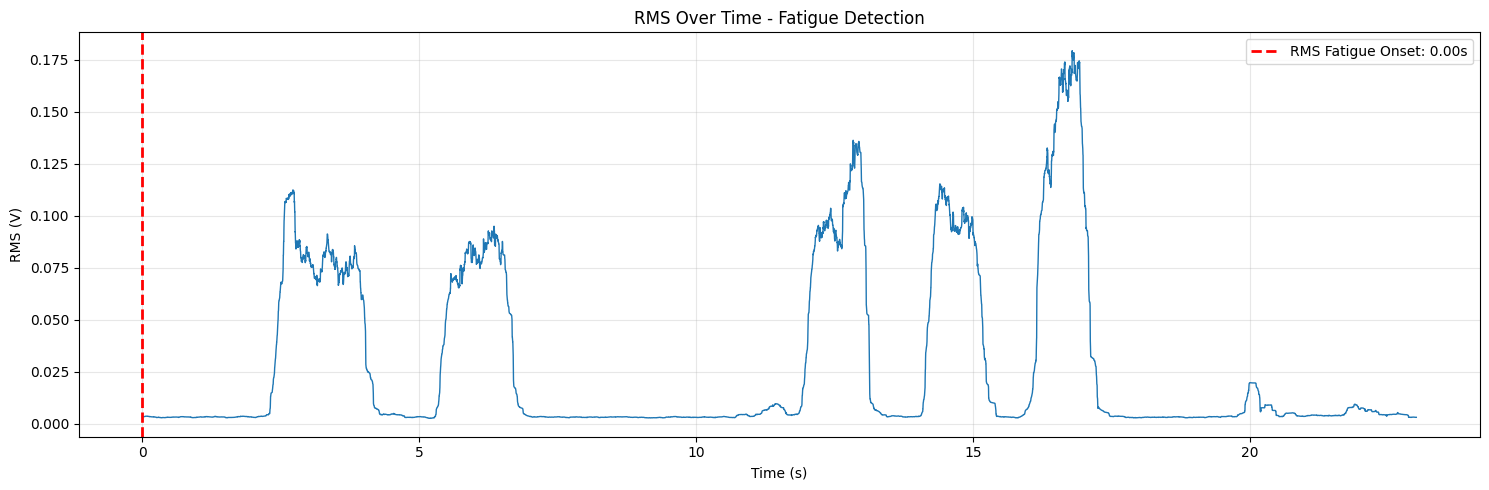

In [ ]:
# Apply notch filter for fatigue analysis
notch_filtered = notch(filtered_signal, freq=NOTCH_FREQ, fs=fs, quality=NOTCH_QUALITY)

# Calculate time to fatigue (using config parameters)
rms_threshold = RMS_FATIGUE_THRESHOLD
mf_threshold = MF_FATIGUE_THRESHOLD

try:
    time_to_rms_fatigue, time_to_mf_fatigue = time_to_fatigue_post(
        filtered_signal, 
        notch_filtered, 
        fs, 
        rms_threshold, 
        mf_threshold
    )
    
    print("Fatigue Analysis Results:")
    print(f"  RMS-based fatigue onset: {time_to_rms_fatigue if time_to_rms_fatigue is not None else 'Not detected'}")
    print(f"  Median frequency-based fatigue onset: {time_to_mf_fatigue if time_to_mf_fatigue is not None else 'Not detected'}")
    
    # Visualize RMS over time
    window_size = int((WINDOW_SIZE_MS / 1000) * fs)  # Convert ms to samples
    rms_sliding = np.sqrt(np.convolve(filtered_signal**2, np.ones(window_size)/window_size, mode='valid'))
    t_rms = np.arange(len(rms_sliding)) / fs
    
    plt.figure(figsize=(15, 5))
    plt.plot(t_rms, rms_sliding, linewidth=1)
    if time_to_rms_fatigue is not None and hasattr(time_to_rms_fatigue, '__len__'):
        plt.axvline(x=time_to_rms_fatigue[0], color='r', linestyle='--', 
                   linewidth=2, label=f'RMS Fatigue Onset: {time_to_rms_fatigue[0]:.2f}s')
    elif time_to_rms_fatigue is not None:
        plt.axvline(x=time_to_rms_fatigue, color='r', linestyle='--', 
                   linewidth=2, label=f'RMS Fatigue Onset: {time_to_rms_fatigue:.2f}s')
    plt.xlabel('Time (s)')
    plt.ylabel('RMS (V)')
    plt.title('RMS Over Time - Fatigue Detection')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Fatigue analysis error: {e}")
    print("Note: This analysis works best with sustained contraction data")

## Summary: EMG Processing Pipeline Results

This notebook demonstrates the complete EMG processing pipeline on BITalino EMG data:

1. **Data Loading**: Single-channel EMG recording from BITalino device
   - File: bitalino_recording_20251117_235117.csv
   - Analog channels: 6 available (Analog0-Analog5)
   - ADC resolution: 10-bit (0-1023)
   - Voltage conversion: 3.3V reference
2. **Signal Characteristics**: 
   - Sampling rate: ~1000 Hz (BITalino default)
   - Duration: ~23 seconds
   - Voltage range: 0-3.3 V (depends on selected channel and sensor)
3. **Filtering**: Bandpass (20-450 Hz) + 60 Hz notch filter
4. **Rectification**: Full-wave rectification for amplitude extraction
5. **Envelope Detection**: Smooth amplitude tracking with 5 Hz low-pass filtering
6. **Feature Extraction**:
   - RMS (Root Mean Square) - muscle activity intensity
   - MAV (Mean Absolute Value) - average muscle activation
7. **Frequency Analysis**: FFT transform shows dominant EMG frequency components
8. **Activation Timing**: Identifies when muscle activation exceeds baseline threshold
9. **Contraction Detection**: Rate-of-change method for robust contraction identification
10. **Fatigue Analysis**: Detects fatigue onset based on RMS and median frequency changes

**To analyze different channels**: Change the `SELECTED_CHANNEL` variable in the data loading cell to 'Analog0', 'Analog1', 'Analog2', etc.

All processing functions are self-contained and use proper filter normalization!